In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential, save_model, load_model
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_percentage_error
import os

2022-11-03 21:08:19.076815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 21:08:19.152382: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-03 21:08:19.155679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 21:08:19.155689: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
df_predictions = pd.read_pickle("./predictions/cpu/predictions.pkl")  
print("df_predictions.shape", df_predictions.shape)
df_predictions.shape

df_predictions.shape (36, 1)


(36, 1)

In [6]:
# read dataset augmented
df_reshaped = pd.read_pickle("./df_reshaped.pkl")  

testing_size = df_predictions.shape[0]
training_size = len(df_reshaped) - testing_size
print("df_reshaped[-training_size:].shape", df_reshaped[-testing_size:].shape)
df_reshaped[-testing_size:]

df_reshaped[-training_size:].shape (36, 4)


,CPUs,MEMs,TEMPs,timestamps
247,76.1905,63.8225,31.562,2022-03-28 00:40:00
248,76.3148,63.8715,31.561,2022-03-28 01:00:00
249,74.8175,63.8725,31.563,2022-03-28 01:20:00
250,73.8182,63.8452,31.562,2022-03-28 01:40:00
251,74.5010,63.8715,31.561,2022-03-28 02:00:00
252,75.0000,63.8483,31.688,2022-03-28 02:20:00
253,75.2852,63.8225,31.562,2022-03-28 02:40:00
254,76.2836,63.8731,31.624,2022-03-28 03:00:00
255,75.6757,63.8467,31.562,2022-03-28 03:20:00
256,77.0909,63.8256,31.562,2022-03-28 03:40:00


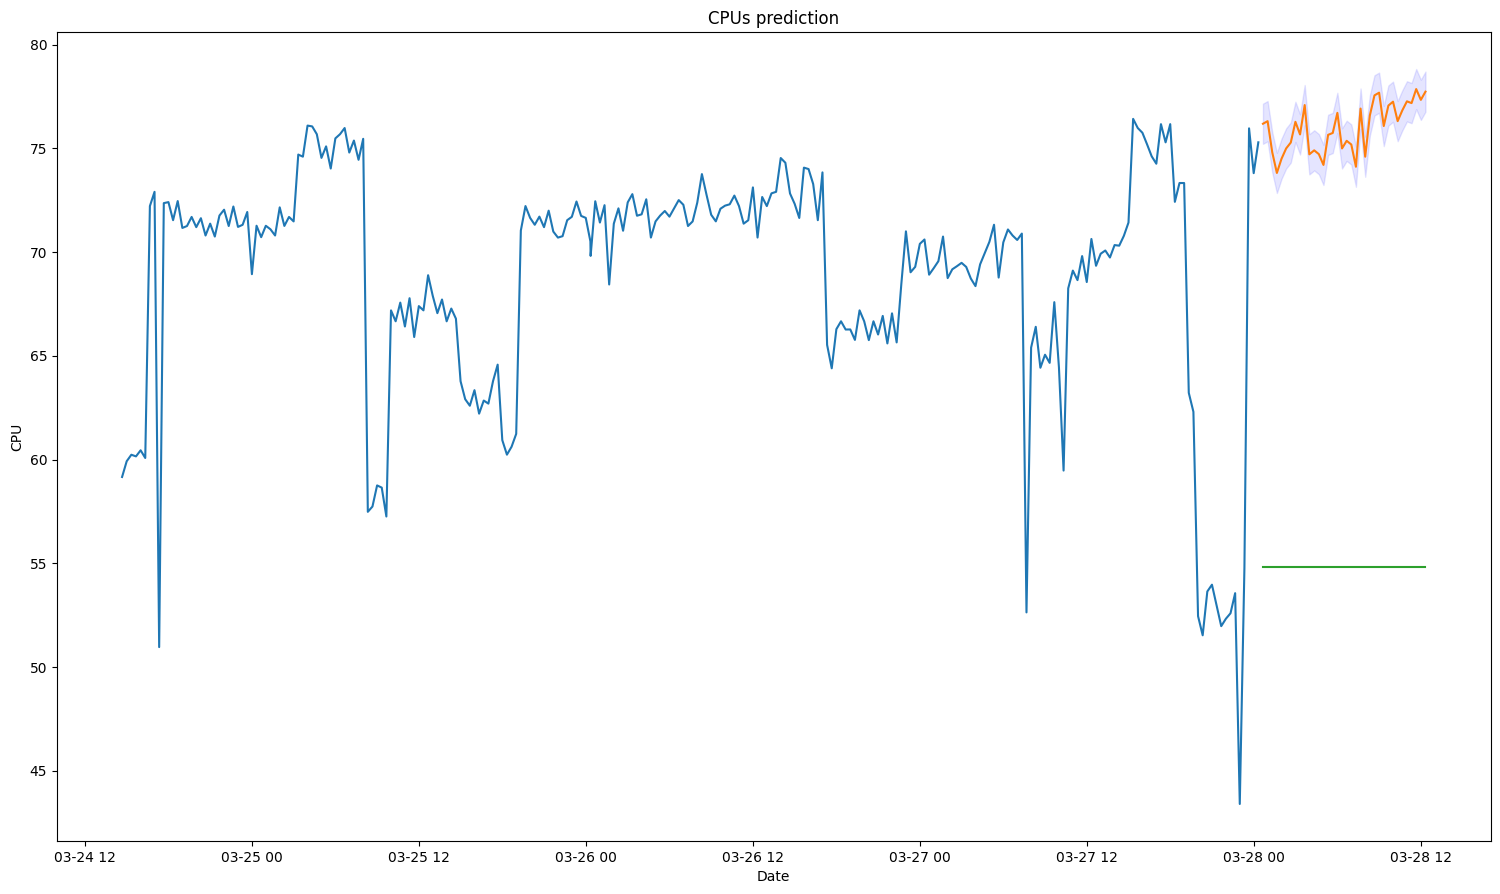

In [7]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5) 

plt.plot(df_reshaped[:-testing_size]["timestamps"], df_reshaped[:-testing_size]["CPUs"])
plt.plot(df_reshaped[training_size:]["timestamps"], df_reshaped[training_size:]["CPUs"])
plt.plot(df_reshaped[training_size:]["timestamps"], df_predictions)
ci = 5 * np.std(df_reshaped[training_size:]["CPUs"])/np.sqrt(len(df_reshaped[training_size:]["CPUs"]))
plt.fill_between(df_reshaped[training_size:]["timestamps"], (df_reshaped[training_size:]["CPUs"]-ci), (df_reshaped[training_size:]["CPUs"]+ci), color='b', alpha=.1)
plt.xlabel('Date')
plt.ylabel('CPU')
plt.title('CPUs prediction')
plt.show()



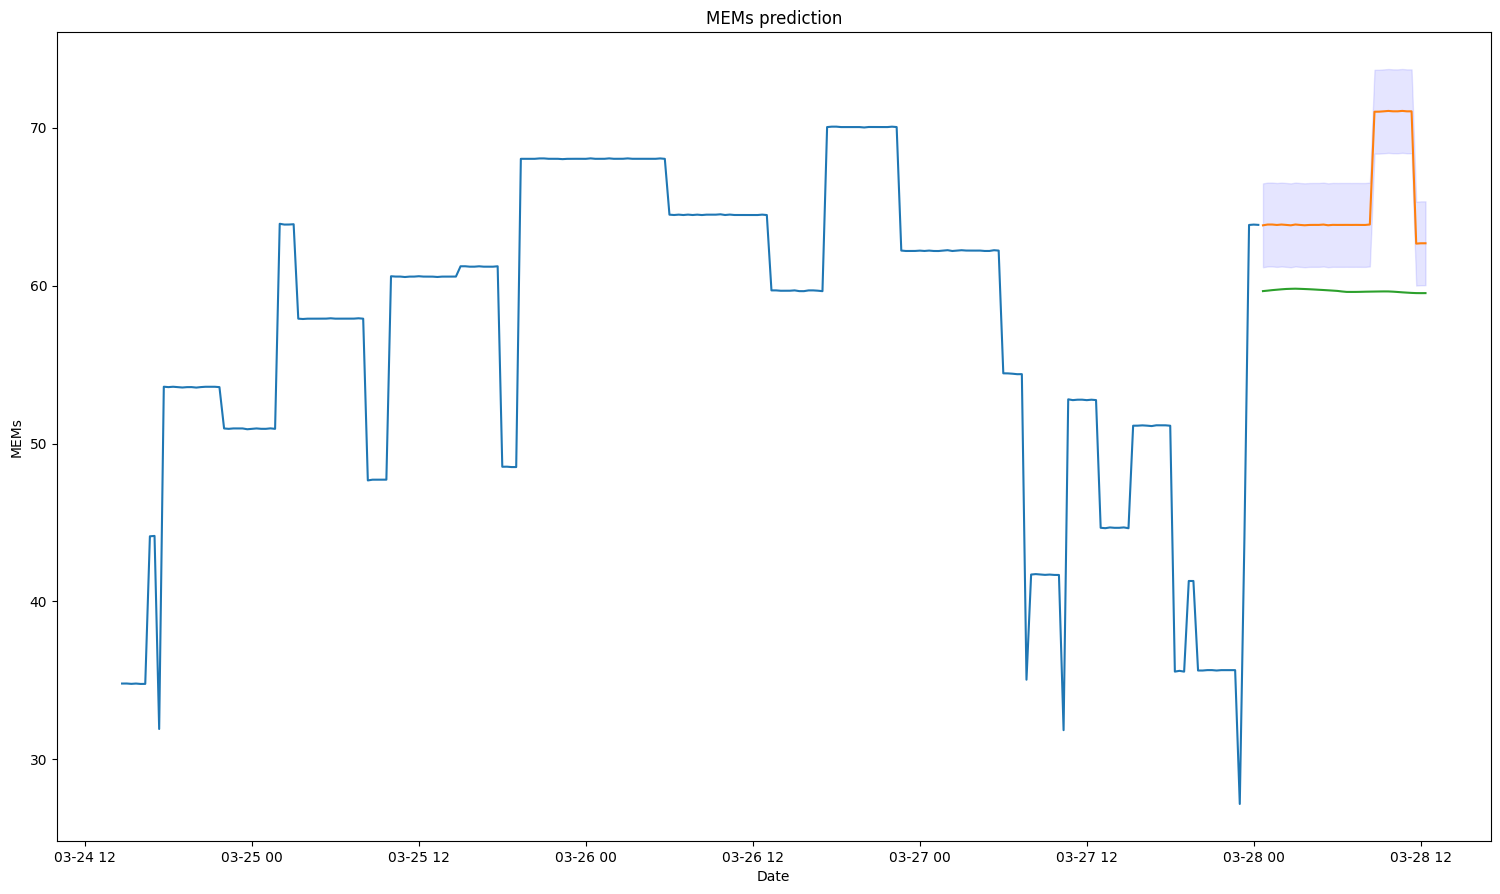

In [79]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5) 

plt.plot(df_reshaped[:-testing_size]["timestamps"], df_reshaped[:-testing_size]["MEMs"])
plt.plot(df_reshaped[training_size:]["timestamps"], df_reshaped[training_size:]["MEMs"])
plt.plot(df_reshaped[training_size:]["timestamps"], df_predictions[:]["MEMs"])
ci = 5 * np.std(df_reshaped[training_size:]["MEMs"])/np.sqrt(len(df_reshaped[training_size:]["MEMs"]))
plt.fill_between(df_reshaped[training_size:]["timestamps"], (df_reshaped[training_size:]["MEMs"]-ci), (df_reshaped[training_size:]["MEMs"]+ci), color='b', alpha=.1)
plt.xlabel('Date')
plt.ylabel('MEMs')
plt.title('MEMs prediction')
plt.show()

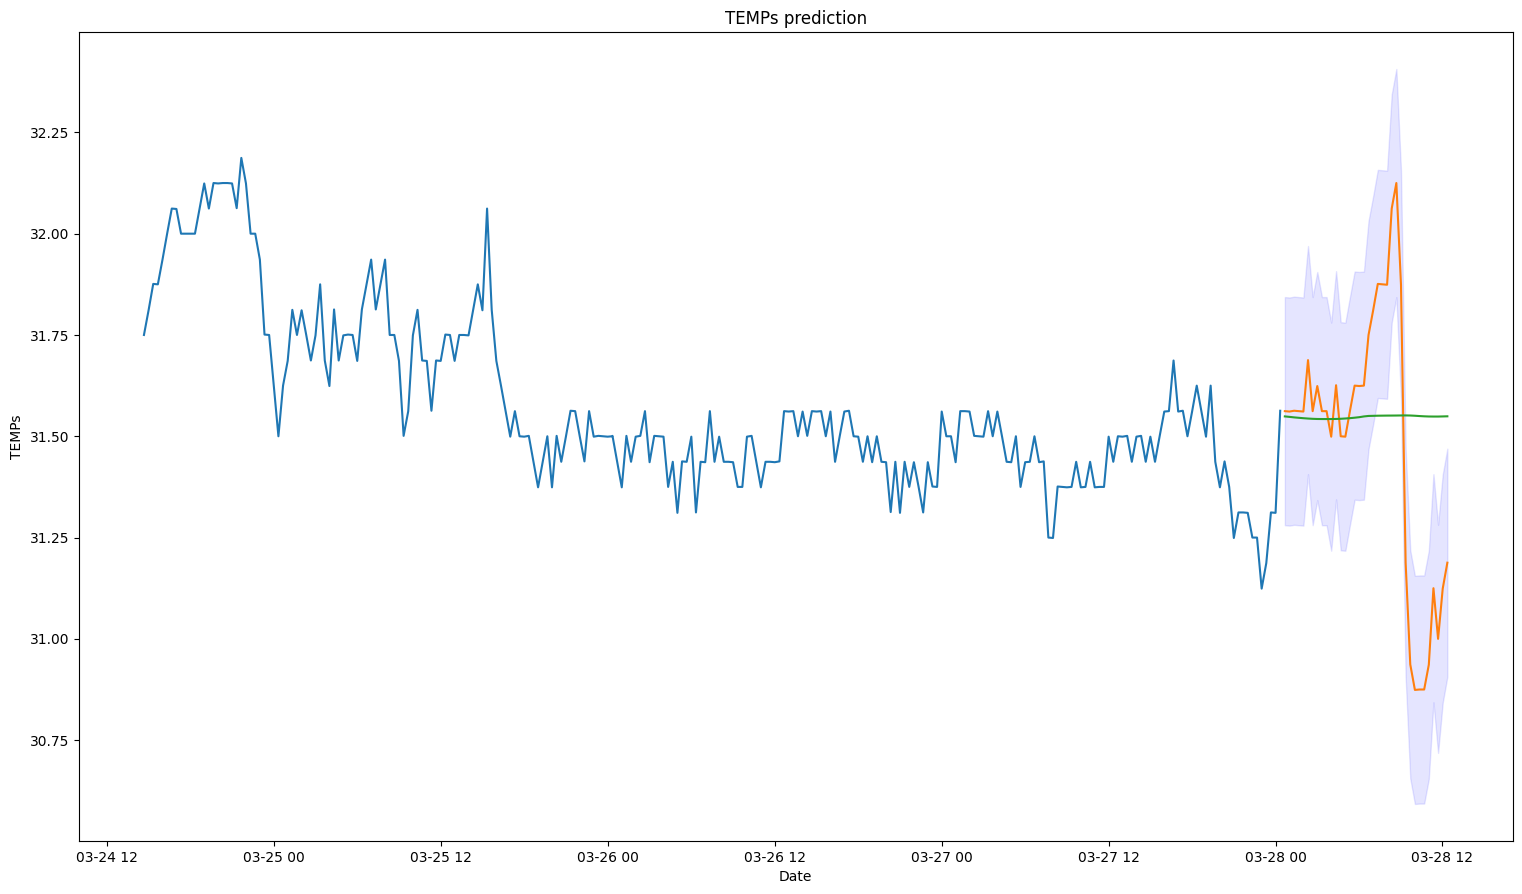

In [77]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5) 

plt.plot(df_reshaped[:-testing_size]["timestamps"], df_reshaped[:-testing_size]["TEMPs"])
plt.plot(df_reshaped[training_size:]["timestamps"], df_reshaped[training_size:]["TEMPs"])
plt.plot(df_reshaped[training_size:]["timestamps"], df_predictions[:]["TEMPs"])
ci = 5 * np.std(df_reshaped[training_size:]["TEMPs"])/np.sqrt(len(df_reshaped[training_size:]["TEMPs"]))
plt.fill_between(df_reshaped[training_size:]["timestamps"], (df_reshaped[training_size:]["TEMPs"]-ci), (df_reshaped[training_size:]["TEMPs"]+ci), color='b', alpha=.1)
plt.xlabel('Date')
plt.ylabel('TEMPs')
plt.title('TEMPs prediction')
plt.show()